In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels
from quantbullet.linear_product_model.utils import init_betas_by_response_mean

## Single Feature Classification Problem

In [36]:
np.random.seed(42)
n_samples = 100_000
x1 = np.random.uniform(0, 4, n_samples)
y = ( x1 - 2 ) ** 2 + np.random.normal(0, 1, n_samples) + 10
df = pd.DataFrame({'x1': x1, 'y': y})

In [37]:
x1_trans = FlatRampTransformer(
    knots = [0.5, 1, 2, 3, 3.5],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() )

In [38]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )

In [39]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist()}

In [40]:
probs = 1 / (1 + np.exp(-(df['y'] - 16)))
df['binary_y'] = np.random.binomial(1, probs)
print(df['binary_y'].mean())

0.02831


## Using SciPy optimizer

In [41]:
from quantbullet.linear_product_model import LinearProductClassifierScipy

lpc_scipy = LinearProductClassifierScipy(ftol=1e-8, gtol=1e-8, eps=1e-3)

In [42]:
lpc_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups )

Using initial params: {'x1': array([0.00087505, 0.00041018, 0.00079288, 0.00142165, 0.00207786,
       0.00270674, 0.0030895 ])}
Iter 1: 12142.853724123024
Iter 2: 12128.790298426853
Iter 3: 12124.368434534588
Iter 4: 12120.16933024289
Iter 5: 12088.91081825008
Iter 6: 11955.241755667803
Iter 7: 11863.446192415335
Iter 8: 11777.379357710623
Iter 9: 11746.483013045441
Iter 10: 11720.68509854015
Iter 11: 11660.527975403807
Iter 12: 11639.04934225207
Iter 13: 11614.784352982388
Iter 14: 11428.944027046457
Iter 15: 11421.156373061196
Iter 16: 11417.910186305653
Iter 17: 11415.673312200566
Iter 18: 11415.487676228262
Iter 19: 11414.761170326841
Iter 20: 11409.89090680009
Iter 21: 11399.38351294947
Iter 22: 11377.066338745653
Iter 23: 11338.13809416763
Iter 24: 11322.765067805236
Iter 25: 11297.467769396573
Iter 26: 11287.06990226635
Iter 27: 11285.437447198135
Iter 28: 11285.186159117997
Iter 29: 11284.261535041178
Iter 30: 11283.721870262647
Iter 31: 11283.04181571323
Iter 32: 11281.673639

In [43]:
df['clf_scipy_pred_prob'] = lpc_scipy.predict(train_df)

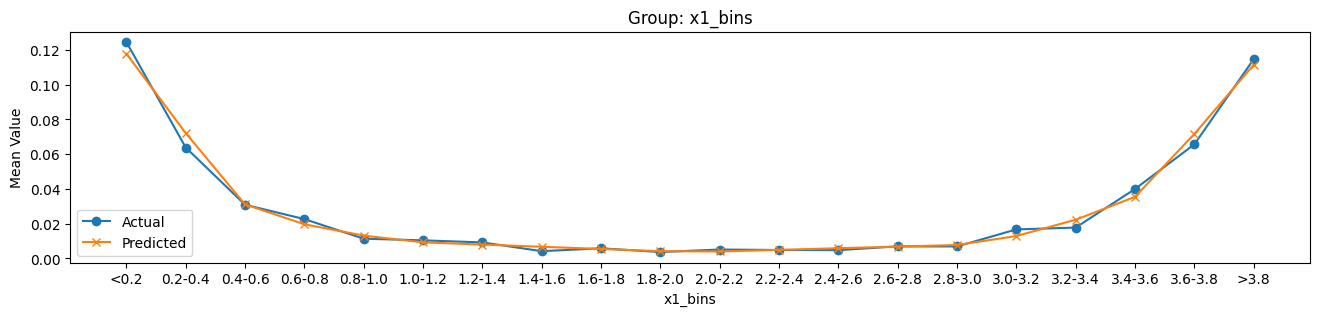

In [44]:
for group in ['x1_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_scipy_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_scipy_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Use $X\beta$ to fit $y$ with Log Loss Minimization

In [45]:
from quantbullet.linear_product_model.utils import minimize_clipped_cross_entropy_loss

In [46]:
beta, res = minimize_clipped_cross_entropy_loss(train_df.values, df['binary_y'].values, eps=1e-3)

In [47]:
df['ce_pred_prob'] = np.clip(train_df.values @ beta, 1e-3, 1 - 1e-3)

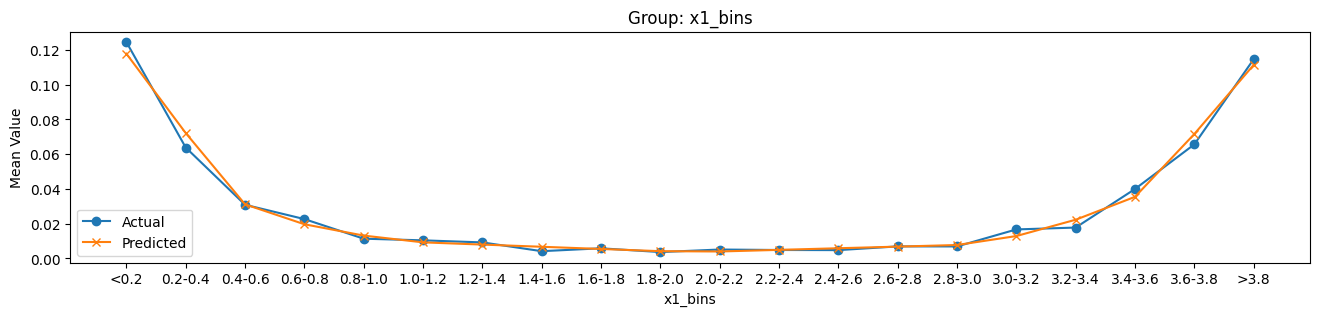

In [48]:
for group in ['x1_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'ce_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['ce_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## BCD Optimization

In [49]:
from quantbullet.linear_product_model import LinearProductClassifierBCD

lpc_bcd = LinearProductClassifierBCD()

In [50]:
lpc_bcd.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=5 )

Using initial params: {'x1': array([0.00087505, 0.00041018, 0.00079288, 0.00142165, 0.00207786,
       0.00270674, 0.0030895 ])}
Iteration 1/5, Loss: 0.1110
Iteration 2/5, Loss: 0.1778
Iteration 3/5, Loss: 0.1965
Iteration 4/5, Loss: 0.1965
Iteration 5/5, Loss: 0.1965


In [51]:
df['clf_bcd_pred_prob'] = lpc_bcd.predict(train_df)

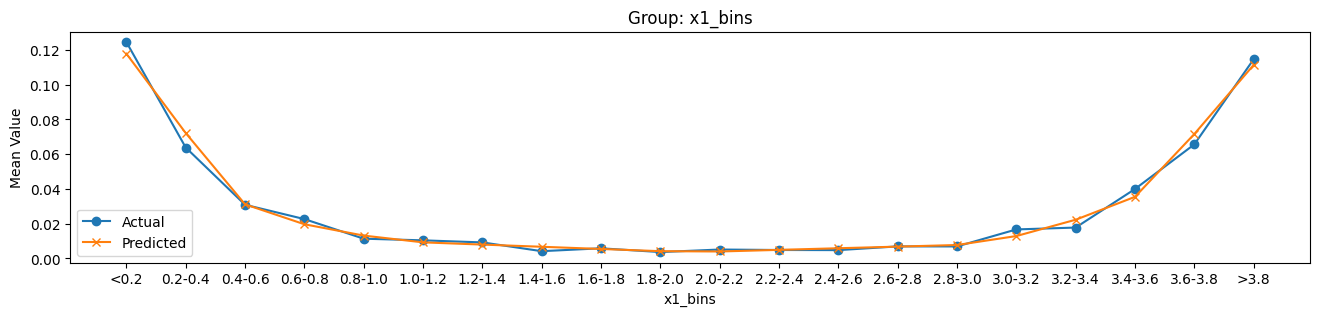

In [52]:
for group in ['x1_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_bcd_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_bcd_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()